# Compare methods of outputting coprecessing waveform
* with and without XPHM multibanding set to zero explicitely

In [1]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Setup the notebook's environment
import lalsimulation as lalsim
from matplotlib.pyplot import *
from numpy import *
from positive import *
from nrutils import scsearch, gwylm
from glob import glob
import xcp
from xcp import determine_data_fitting_region,calibration_catalog,metadata_dict,template_amp_phase,get_xphm_coprec

(positive)>> Applying custom matplotlib settings.
(init)>> Warm greetings from XCP.
(xcp.core)>> Catalog of calibration runs stored to "xcp.calibration_catalog"
(xcp.core)>> Metadata dictionary for calibration runs stored to "xcp.metadata_dict"
(xcp.core)>> Metadata dictionary for Ed's catalog paper stored to "xcp.catalog_paper_metadata"


In [2]:
# Let the user know where lalsimulation lives

#
lalsim_path = lalsim.__path__[0]
lalsuite_repo_path = lalsim_path.split('lib')[0]+'src/lalsuite/'
branch_name = bash('cd %s && git status'%lalsuite_repo_path).decode("utf-8").split('On branch ')[-1].split('\n')[0]

#
alert('We are getting our LALSimulation from:\n%s\n'%magenta(lalsim_path))
alert('We think that the related lalsuite source files are here:\n%s\n'%green(lalsuite_repo_path))
alert('Lastly, we are currently on this branch: %s\n'%bold(magenta(branch_name)))

#
if branch_name != 'pnrv1-ll':
    alert('We are not on the expected branch. This may cause unexpected behavior.',say=True)

(notebook)>> We are getting our LALSimulation from:
/Users/book/opt/anaconda2/envs/hack-phenomx3/lib/python3.6/site-packages/lalsimulation

(notebook)>> We think that the related lalsuite source files are here:
/Users/book/opt/anaconda2/envs/hack-phenomx3/src/lalsuite/

(notebook)>> Lastly, we are currently on this branch: pnrv1-ll



/Users/book/opt/anaconda2/envs/hack-phenomx3/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


[ 5.11294793e-02 -1.40026250e-01  1.93276630e-03 -8.54802467e-04
 -1.04260310e-02  1.33144330e-04  4.03753443e-06  4.02881121e-02]
(notebook)>> Done.


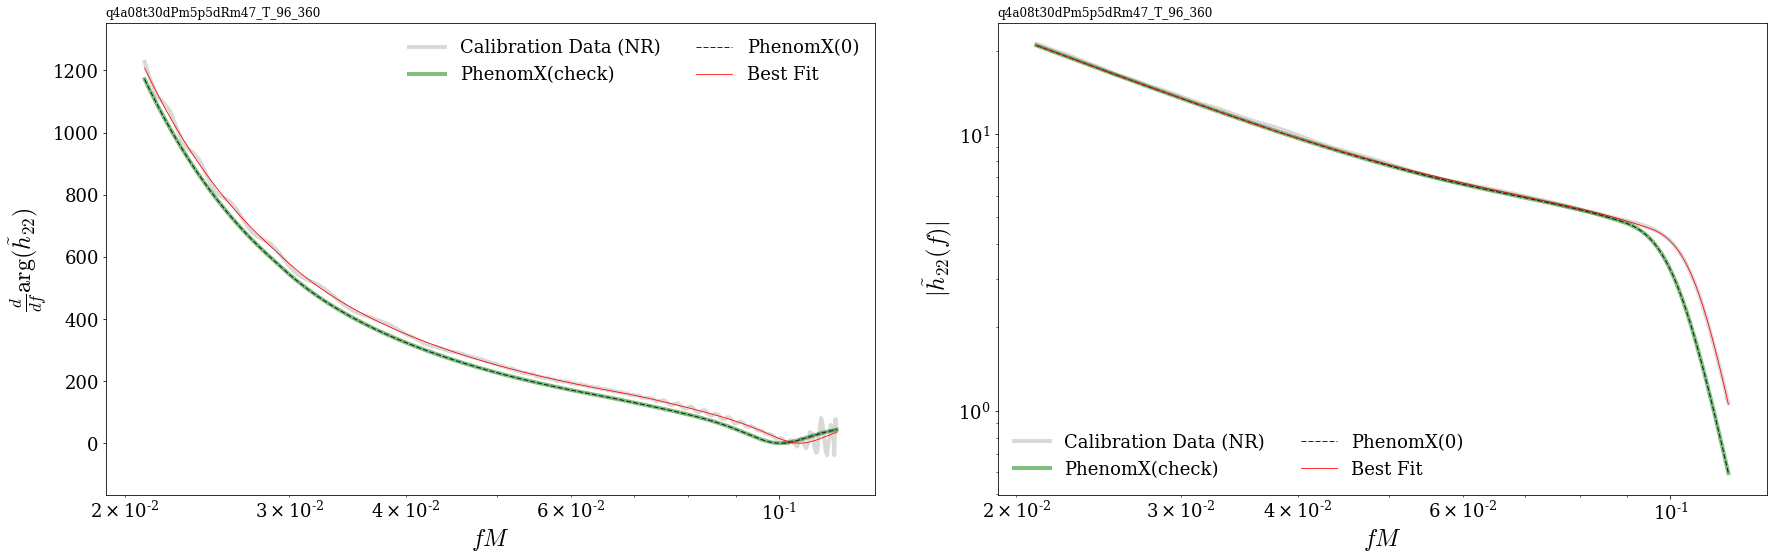

In [3]:

#
from numpy.linalg import norm
from scipy.optimize import curve_fit,minimize,fmin

#
ll = 2

#
datadir = '/Users/book/KOALA/PhenomXCP/data/version2/'
files = glob( datadir+'*_l%im%i.txt'%(ll,ll) )
files.sort()

files = files[::-1]

#
# fig,ax = subplots( len(files), 2, figsize=3*array([ 2.5*2/(0.618), 2.0*len(files) ]) )
fig,ax = subplots( 1, 2, figsize=3*array([ 2.5*2/(0.618), 2.5*1 ]), sharex=True)
ax = ax.flatten()

#
tight_layout(1,2,4)

#
foo = {}

#
lmlist = [ (ll,ll) ]

# Get number of parameters to be tuned
scarecrow = template_amp_phase(0.5, 0.5,zeros(3),zeros(3),ell=2)
var_count = scarecrow.__code__.co_argcount - 1

#
p = 0
for f_ in files[::-1]:
    
    if 'q4a08t30' in f_:#'q8a08t30' in f_:

        #
        simname = f_.split('/')[-1].split('_l%im%i.'%(ll,ll))[0]

        # Find index location of metadata for simname 
        k = [ k for k,val in enumerate(metadata_dict['simname']) if val in simname ][0]

        # Load data for this case
        raw_data = loadtxt(f_).T
        calibration_data, dphi_lorentzian_min, f_min, f_max, f_lorentzian_min = determine_data_fitting_region( raw_data )

        # Collect params for this case 
        metadata = metadata_dict['array_data'][k,:]

        #
        f,amp_fd,dphi_fd,alpha,beta,gamma = calibration_data.T
        theta,m1,m2,eta,delta,chi_eff,chi_p,chi1,chi2,a1,a2,chi1_x,chi1_y,chi1_z,chi2_x,chi2_y,chi2_z = metadata_dict['array_data'][k]
    
        #
        chi1_vec = array([chi1_x,chi1_y,chi1_z])
        chi2_vec = array([chi2_x,chi2_y,chi2_z])
        
        #
        action_helper = template_amp_phase(m1, m2, chi1_vec, chi2_vec,ell=2)
        def action( p, verbose=False, output_vars=False ):
            #
            if verbose: print(p)
            amplitude,phase_derivative = action_helper( f, *p )
            # -- Calculate residual of phase derivative -- #
            residual_phase_derivative = sum((dphi_fd - phase_derivative)**2) / std(dphi_fd)
            # -- Calculate residual of amplitude --------- #
            amp_scale = f ** (7.0/6)
            inv_amp_scale = f ** (-7.0/6)
            log_scaled_amp_fd = log( amp_fd * amp_scale )
            log_scaled_amplitude = log( amplitude * amp_scale )
            residual_amplitude = sum((log_scaled_amp_fd - log_scaled_amplitude)**2) / std(log_scaled_amp_fd)
            # -- Combine residuals ----------------------- #
            combined_residual = residual_phase_derivative + residual_amplitude
            #
            if output_vars:
                return (combined_residual,p)
            #
            return combined_residual
        
        #
        foo = minimize( action,zeros(var_count) )
        best_fit_amp,best_fit_dphi = action_helper( f, *foo.x )
        print(foo.x)
        
        #
        mod_xhm0_amp,mod_xhm0_dphi = action_helper(f)
        check_xhm0_amp,check_xhm0_dphi = template_amp_phase(m1, m2, chi1_vec, chi2_vec,ell=2,__set_XPHMThresholdMband__=False)(f)
        
        check2_freqs,check2_h_pos,check2_h_neg = get_xphm_coprec(2,-2, 100.0, m1/m2, chi1_vec, chi2_vec, pnr=True)
        
        

        # PLOTTING
        # ---

        #
        sca(ax[p]); p+=1
#         #plot( f, phenomd_dphi, label='PhenomD', ls='--',alpha=0.3,color='k' )
        plot( f, dphi_fd, label='Calibration Data (NR)', lw=4,ls='-', alpha=0.15, color='k' )
#         plot( f, mod_xhm_dphi, label='PhenomX(500)', ls='--',lw=1,alpha=0.85,color='b' )
        plot( f, check_xhm0_dphi, label='PhenomX(check)', ls='-',lw=4,alpha=0.5,color='g',zorder=-11 )
        plot( f, mod_xhm0_dphi, label='PhenomX(0)', ls='--',lw=1,alpha=0.85,color='k',zorder=-10 )
        plot( f, best_fit_dphi, label='Best Fit', color='r', ls='-' )
        xscale('log')
        xlim(lim(f,dilate=1.1,dilate_with_multiply=True))
        ylim( limy(f, dphi_fd,dilate=0.1) )
#         #plot( f, best_fit_dphi2, label='Best Fit (phi fit)', color='b', ls='-' )
        title(simname,size=12,loc='left')
        legend(ncol=2,loc=1)
        ylabel(r'$\frac{d}{df}\arg(\tilde{h}_{22})$')
        xlabel('$fM$')
#         if p==(len(files)-2):  xlabel('$fM$')
#         #
        title(simname,loc='left',size=12)

#         #subplot(1,2,2)
        sca(ax[p]); p+=1
#         plot( f, phenomd_amp, label='PhenomD', ls='--',alpha=0.9,color='k' )
        plot( f, amp_fd, label='Calibration Data (NR)', lw=4,ls='-', alpha=0.15, color='k' )
#         plot( f, mod_xhm_amp, label='PhenomX(500)', ls='--',lw=1,alpha=0.85,color='b' )
        plot( f, check_xhm0_amp, label='PhenomX(check)', ls='-',lw=4,alpha=0.5,color='g',zorder=-11 )
        plot( f, mod_xhm0_amp, label='PhenomX(0)', ls='--',lw=1,alpha=0.85,color='k',zorder=-10 )
        plot( f, best_fit_amp, label='Best Fit', color='r', ls='-' )
        # plot( check2_freqs, abs(check2_h_neg), label='check2', lw=6 )
#         title(simname,size=12,loc='left')
        yscale('log')
        xscale('log')
        legend(ncol=2,loc=3)
        #ylim( limy(f, amp_fd,dilate=1.2) )
        xlabel('$fM$')
        ylabel(r'$|\tilde{h}_{22}(f)|$')
        #
        title(simname,loc='left',size=12)
        

alert('Done.')

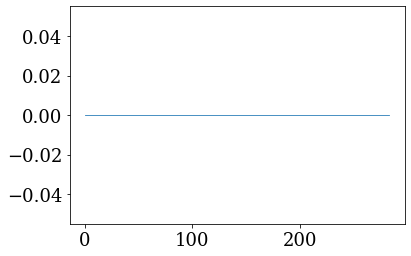

In [4]:
# plot( check2_freqs, abs(check2_h_neg), label='check2', lw=6 )
plot( mod_xhm0_amp-check_xhm0_amp )

# Summary

* We have compared the coprecessing waveforms produced by two slightly different methods
* With and without XPHM multibanding explicitely set to zero
* Both yield the same result -- their difference is zero